<a href="https://colab.research.google.com/github/AubLambert/FraudDetection/blob/quang/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
!pip install catplot

# Basic Analysis

## Import Data

In [ ]:
# Set pandas option to display all columns
pd.set_option('display.max_columns', None)

# Optional: Set the width to avoid line breaks
pd.set_option('display.width', None)

df = pd.read_csv('fraudTrain.csv', on_bad_lines='warn')  # or 'skip' or 'error'
df

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,Hatch,UT,84735,37.7175,-112.4777,258,Geoscientist,1961-11-24,440b587732da4dc1a6395aba5fb41669,1371816728,36.841266,-111.690765,0
1296671,1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,Tuscarora,MD,21790,39.2667,-77.5101,100,"Production assistant, television",1979-12-11,278000d2e0d2277d1de2f890067dcc0a,1371816739,38.906881,-78.246528,0
1296672,1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,High Rolls Mountain Park,NM,88325,32.9396,-105.8189,899,Naval architect,1967-08-30,483f52fe67fabef353d552c1e662974c,1371816752,33.619513,-105.130529,0
1296673,1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,Manderson,SD,57756,43.3526,-102.5411,1126,Volunteer coordinator,1980-08-18,d667cdcbadaaed3da3f4020e83591c83,1371816816,42.788940,-103.241160,0


In [ ]:
df = df.drop('Unnamed: 0', axis=1)

# Descriptive Statistics

In [ ]:
df.describe()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,4.171920e+17,7.035104e+01,4.880067e+04,3.853762e+01,-9.022634e+01,8.882444e+04,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03
std,1.308806e+18,1.603160e+02,2.689322e+04,5.075808e+00,1.375908e+01,3.019564e+05,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02
min,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00
25%,1.800429e+14,9.650000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00
50%,3.521417e+15,4.752000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00
75%,4.642255e+15,8.314000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00
max,4.992346e+18,2.894890e+04,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.371817e+09,6.751027e+01,-6.695090e+01,1.000000e+00


In [ ]:
df.shape

(1296675, 22)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop          

In [ ]:
df.isnull().sum()

,0
trans_date_trans_time,0
cc_num,0
merchant,0
category,0
amt,0
first,0
last,0
gender,0
street,0
city,0


In [ ]:
df.select_dtypes(include=['int64', 'float64']).nunique()

,0
cc_num,983
amt,52928
zip,970
lat,968
long,969
city_pop,879
unix_time,1274823
merch_lat,1247805
merch_long,1275745
is_fraud,2


In [ ]:
df.select_dtypes(include=['object', 'category']).nunique()

,0
trans_date_trans_time,1274791
merchant,693
category,14
first,352
last,481
gender,2
street,983
city,894
state,51
job,494


# EDA

In [ ]:
# Create a copy for EDA
df_viz = df.copy()

## Fraud Distribution

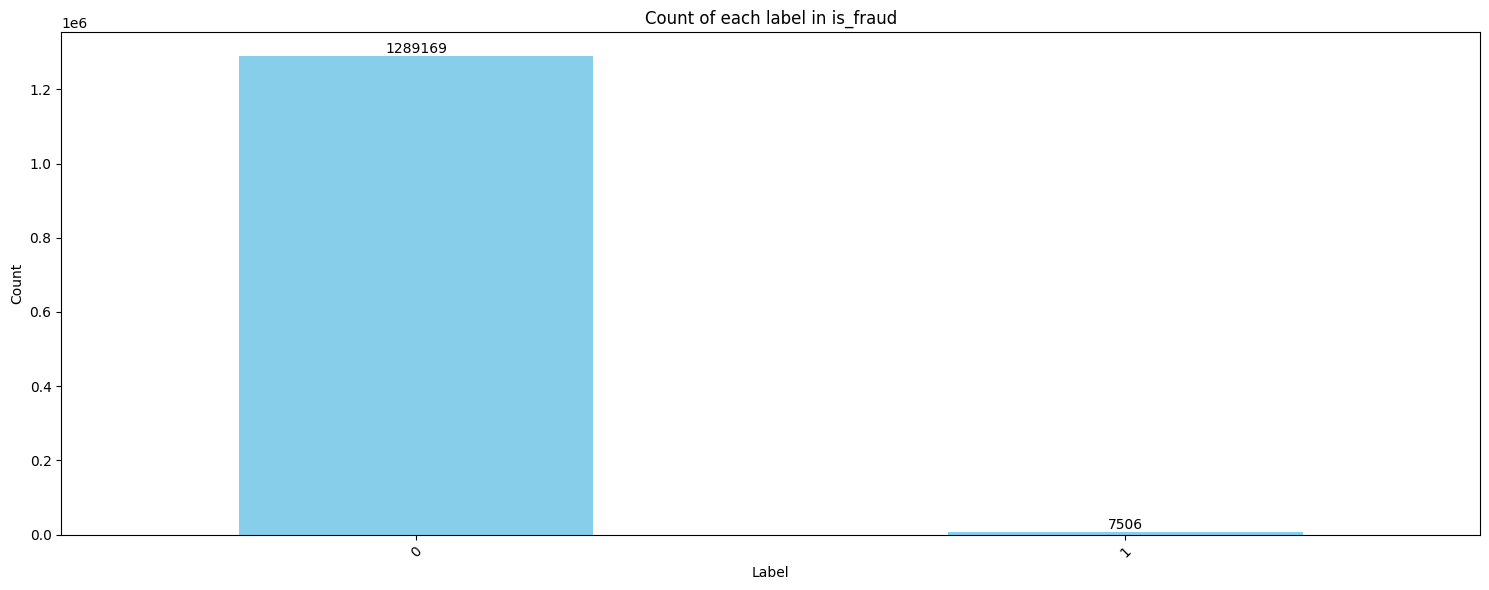

In [ ]:
def cat_plot(df, column):
    counts = df[column].value_counts()

    plt.figure(figsize=(15, 6))
    ax = counts.plot(kind='bar', color='skyblue')

    # Add labels on top of bars
    for i, v in enumerate(counts):
        ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=10)

    plt.title(f"Count of each value in {column}")
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

cat_plot(df_viz, "is_fraud")

In [ ]:
fraud_percent = (df['is_fraud'] == 1).sum()/(df.shape[0])

print(f"Fraud Percentage: {fraud_percent * 100:.5f}%")

Fraud Percentage: 0.57887%


## Date and Time Heatmap


### Transaction

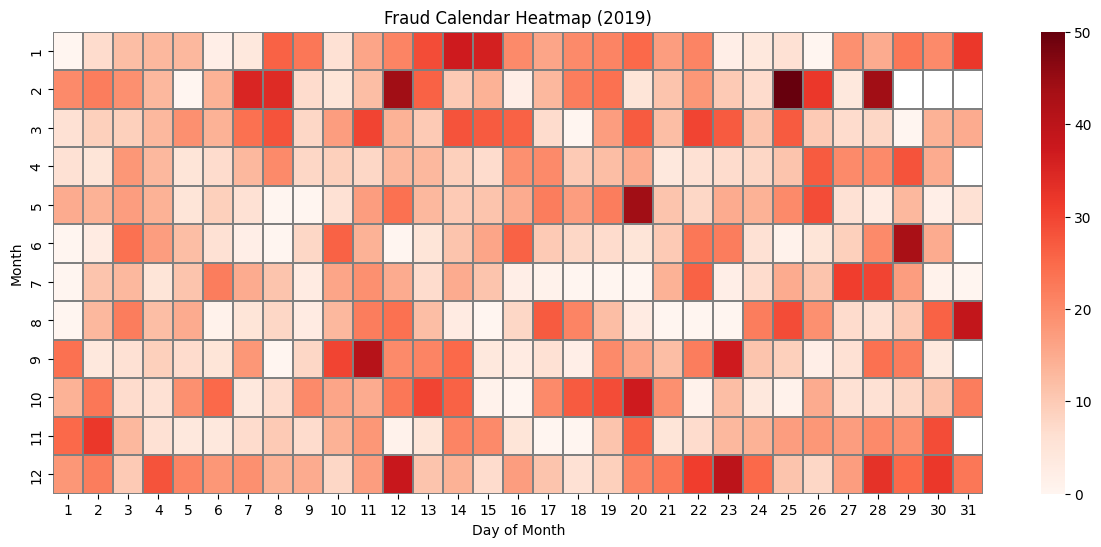

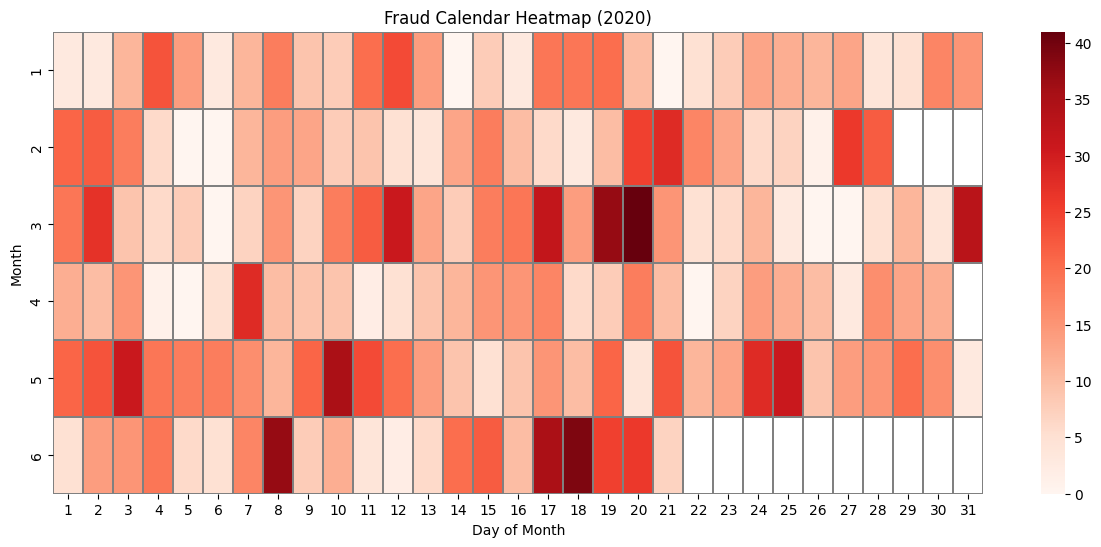

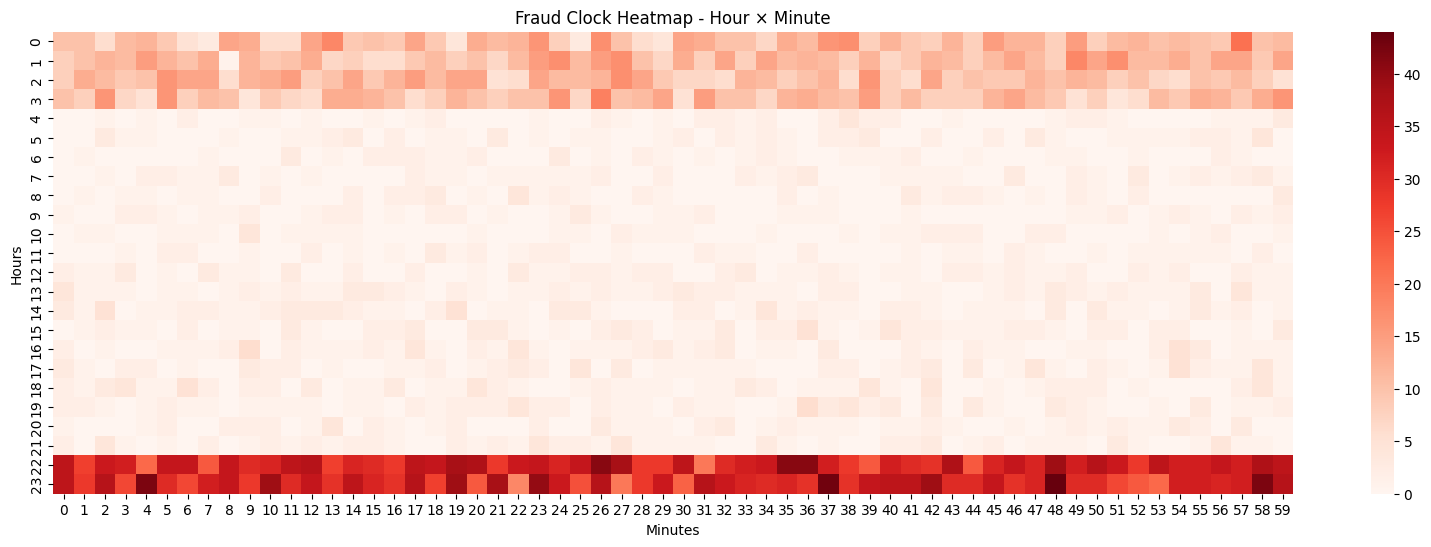

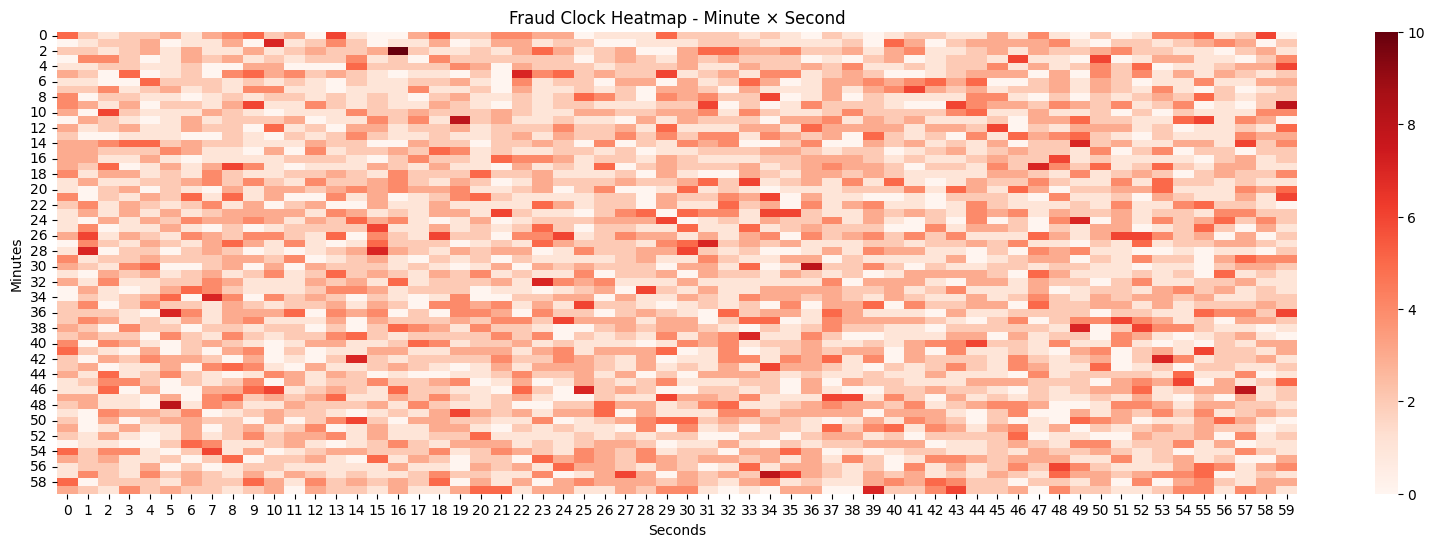

In [ ]:
df_viz["trans_date_trans_time"] = pd.to_datetime(df_viz["trans_date_trans_time"])
df_viz["year"] = df_viz["trans_date_trans_time"].dt.year
df_viz["month"] = df_viz["trans_date_trans_time"].dt.month
df_viz["day"] = df_viz["trans_date_trans_time"].dt.day
df_viz["hour"] = df_viz["trans_date_trans_time"].dt.hour
df_viz["minute"] = df_viz["trans_date_trans_time"].dt.minute
df_viz["second"] = df_viz["trans_date_trans_time"].dt.second

# =====================================================
# 1) CALENDAR HEATMAP (Year × Month × Day)
# =====================================================
fraud_calendar = df_viz.groupby(["year","month","day"])["is_fraud"].sum().reset_index()

for yr in sorted(fraud_calendar["year"].unique()):
    pivoted = fraud_calendar[fraud_calendar["year"]==yr].pivot(
        index="month", columns="day", values="is_fraud"
    )

    plt.figure(figsize=(15,6))
    sns.heatmap(pivoted, cmap="Reds", cbar=True, linewidths=0.1, linecolor="grey")
    plt.title(f"Fraud Calendar Heatmap ({yr})")
    plt.xlabel("Day of Month")
    plt.ylabel("Month")
    plt.show()

# =====================================================
# 2) CLOCK HEATMAP (Hour × Minute)
# =====================================================

fraud_clock_min = df_viz.groupby(["hour","minute"])["is_fraud"].sum().reset_index()

pivoted_clock_min = fraud_clock_min.pivot_table(
    index="hour", columns="minute", values="is_fraud", fill_value=0
)

plt.figure(figsize=(20,6))
sns.heatmap(pivoted_clock_min, cmap="Reds", cbar=True)
plt.title("Fraud Clock Heatmap - Hour × Minute")
plt.xlabel("Minutes")
plt.ylabel("Hours")
plt.show()

fraud_clock_sec = df_viz.groupby(["minute","second"])["is_fraud"].sum().reset_index()

pivoted_clock_sec = fraud_clock_sec.pivot_table(
    index="minute", columns="second", values="is_fraud", fill_value=0
)

plt.figure(figsize=(20,6))
sns.heatmap(pivoted_clock_sec, cmap="Reds", cbar=True)
plt.title("Fraud Clock Heatmap - Minute × Second")
plt.xlabel("Seconds")
plt.ylabel("Minutes")
plt.show()

### DoB

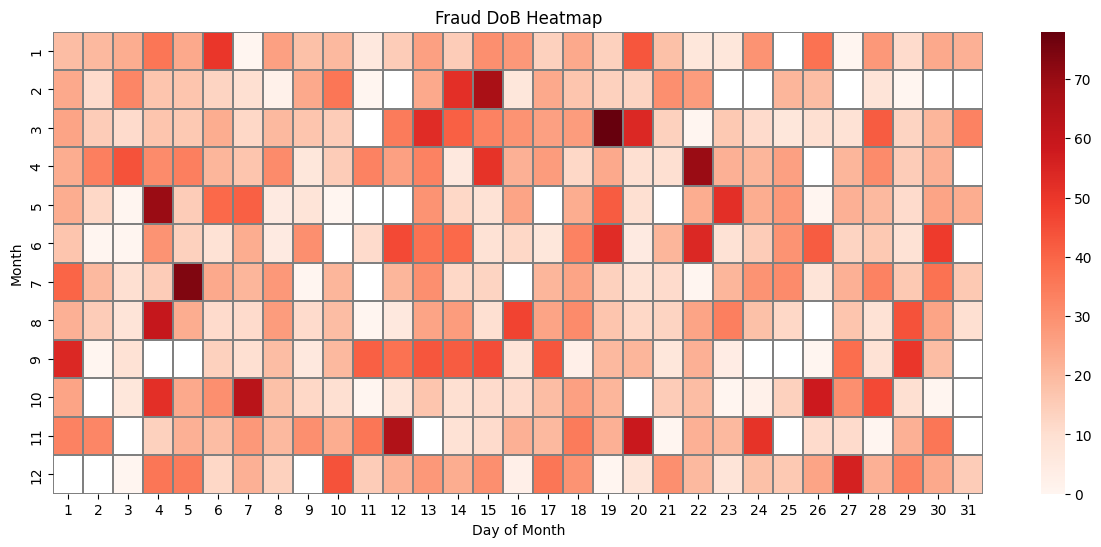

In [ ]:
df_viz["dob"] = pd.to_datetime(df_viz["dob"])
df_viz["dob_year"] = df_viz["dob"].dt.year
df_viz["dob_month"] = df_viz["dob"].dt.month
df_viz["dob_day"] = df_viz["dob"].dt.day

fraud_dob = df_viz.groupby(["dob_month","dob_day"])["is_fraud"].sum().reset_index()

pivoted = fraud_dob.pivot(
    index="dob_month", columns="dob_day", values="is_fraud"
)

plt.figure(figsize=(15,6))
sns.heatmap(pivoted, cmap="Reds", cbar=True, linewidths=0.1, linecolor="grey")
plt.title(f"Fraud DoB Heatmap")
plt.xlabel("Day of Month")
plt.ylabel("Month")
plt.show()

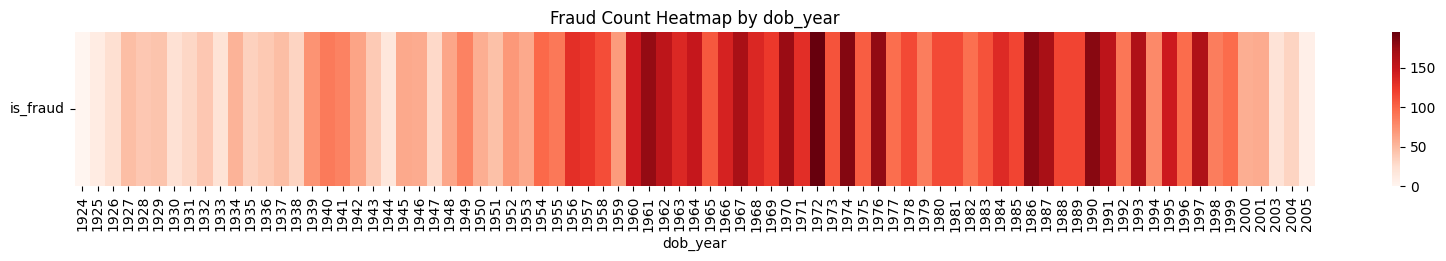

In [ ]:
def feature_to_target(df, column):
    partition = df.groupby(column)["is_fraud"].sum().reset_index()

    # reshape into 1-row dataframe
    heatmap_data = partition.set_index(column).T

    plt.figure(figsize=(20, 2))
    sns.heatmap(
        heatmap_data,
        cmap="Reds",
        annot=False,  # disable is_fraud count labels
        cbar=True
    )
    plt.title(f"Fraud Count Heatmap by {column}")
    plt.yticks(rotation=0)
    plt.show()

feature_to_target(df_viz, "dob_year")

## Calculate distance between merchants and customers

In [ ]:
def haversine_vectorized(lat1, lon1, lat2, lon2):
    # Convert to radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Earth radius in kilometers
    return r * c

# Example usage with your DataFrame df
df_viz['distance_km'] = haversine_vectorized(
    df['lat'], df['long'], df['merch_lat'], df['merch_long']
)

In [ ]:
df_viz["distance_km"].nunique()

1296675

In [ ]:
df["category"].unique()

array(['misc_net', 'grocery_pos', 'entertainment', 'gas_transport',
       'misc_pos', 'grocery_net', 'shopping_net', 'shopping_pos',
       'food_dining', 'personal_care', 'health_fitness', 'travel',
       'kids_pets', 'home'], dtype=object)

## Concatenate customer_name

In [ ]:
df_viz["customer_name"] = df_viz["first"].str.cat(df_viz["last"], sep='')

In [ ]:
df_viz["customer_name"].nunique()

973

## Split job

In [ ]:
def split_jobs(df, col="job"):
    # Split by comma → expand into lists
    job_splits = df[col].str.split(",")

    # Find maximum number of jobs in any row
    max_jobs = job_splits.map(len).max()

    # Create new DataFrame with expanded columns
    job_df = pd.DataFrame(job_splits.tolist(), index=df.index)

    # Rename columns as job_1, job_2, ...
    job_df = job_df.rename(columns={i: f"job_{i+1}" for i in range(max_jobs)})

    # Trim whitespace from each job string
    job_df = job_df.apply(lambda col: col.str.strip() if col.dtype == "object" else col)

    # Concatenate back with original DataFrame (optional)
    df_expanded = pd.concat([df, job_df], axis=1)

    return df_expanded

# Example usage
df_viz = split_jobs(df_viz, col="job")

In [ ]:
df_viz.nunique()

,0
trans_date_trans_time,1274791
cc_num,983
merchant,693
category,14
amt,52928
first,352
last,481
gender,2
street,983
city,894


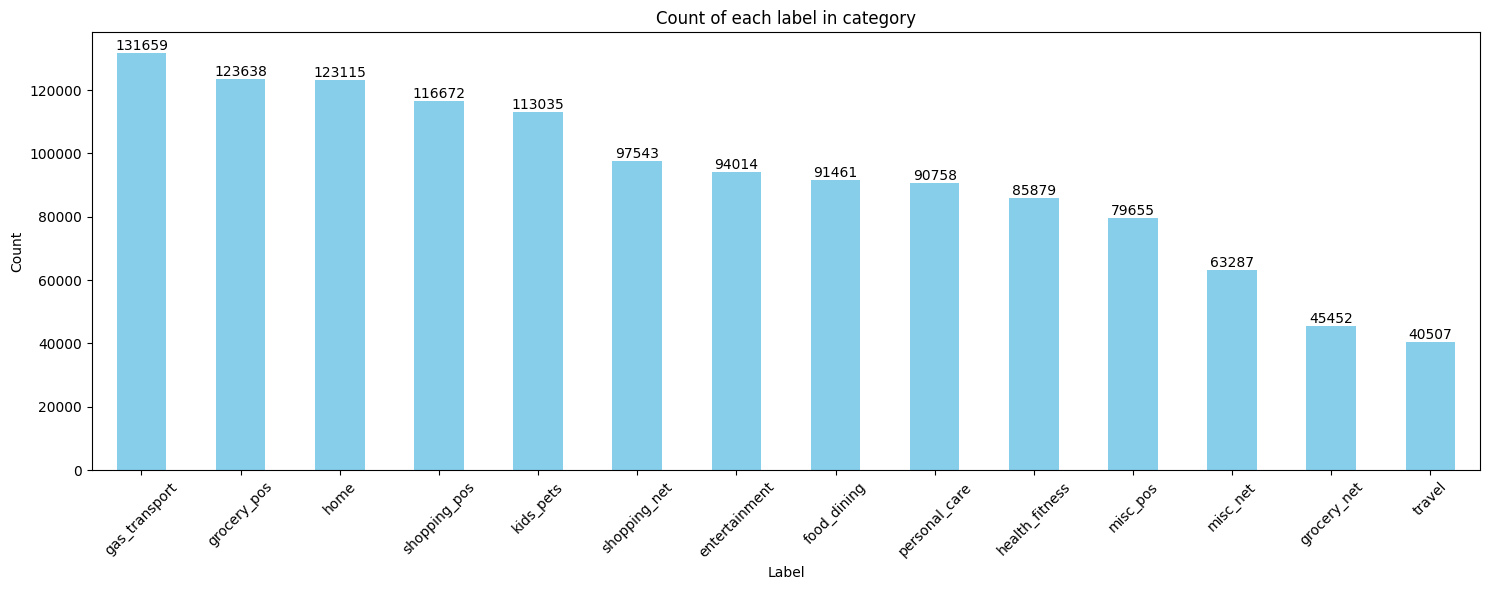

In [ ]:
cat_plot(df_viz, "category")

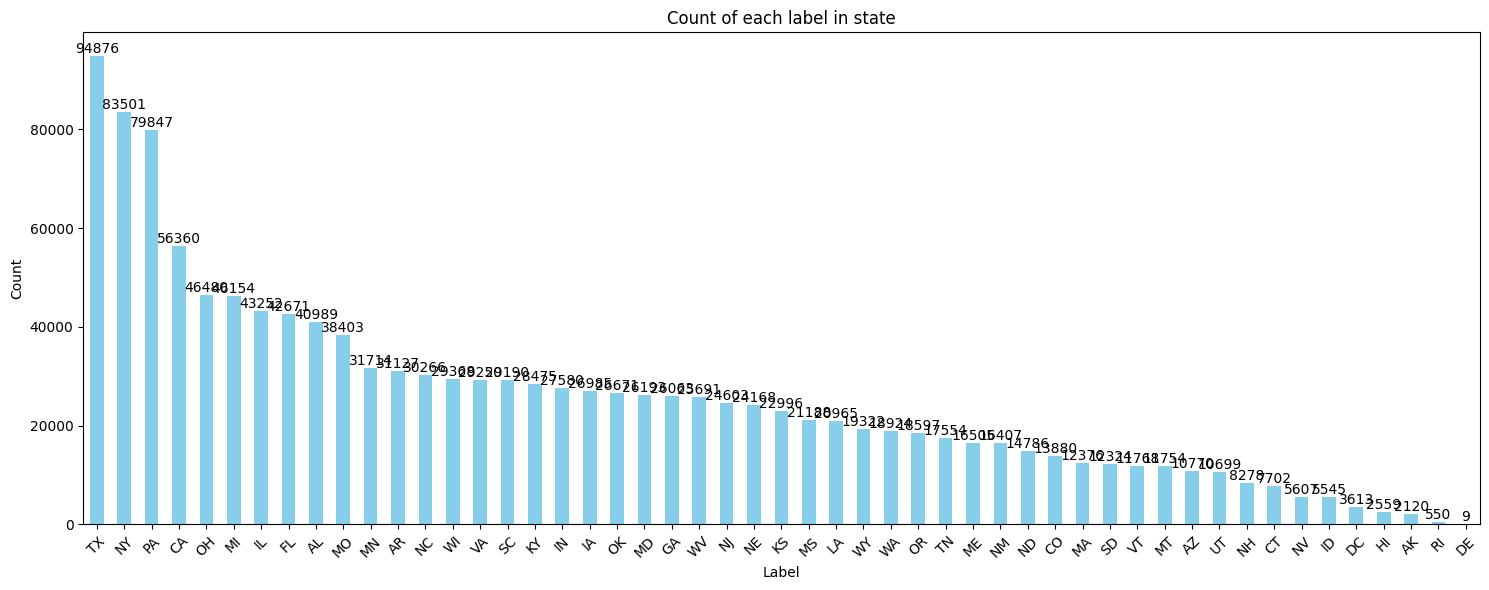

In [ ]:
cat_plot(df_viz, "state")

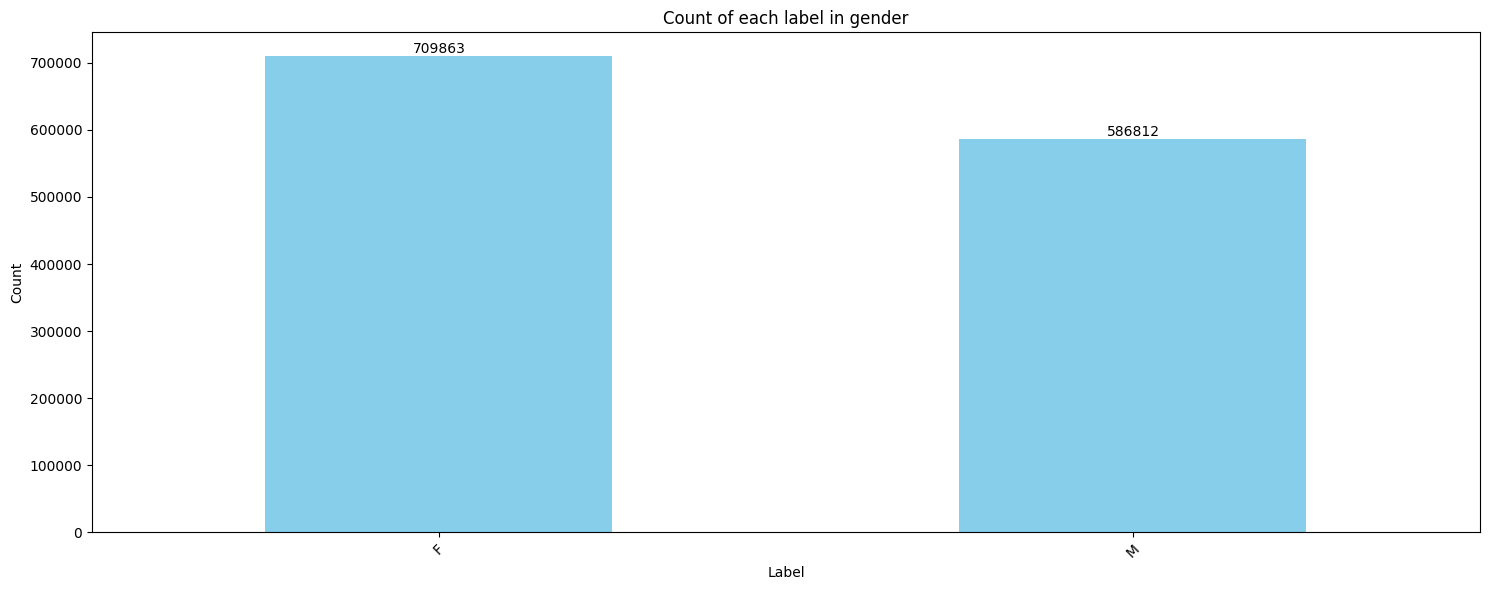

In [ ]:
cat_plot(df_viz, "gender")

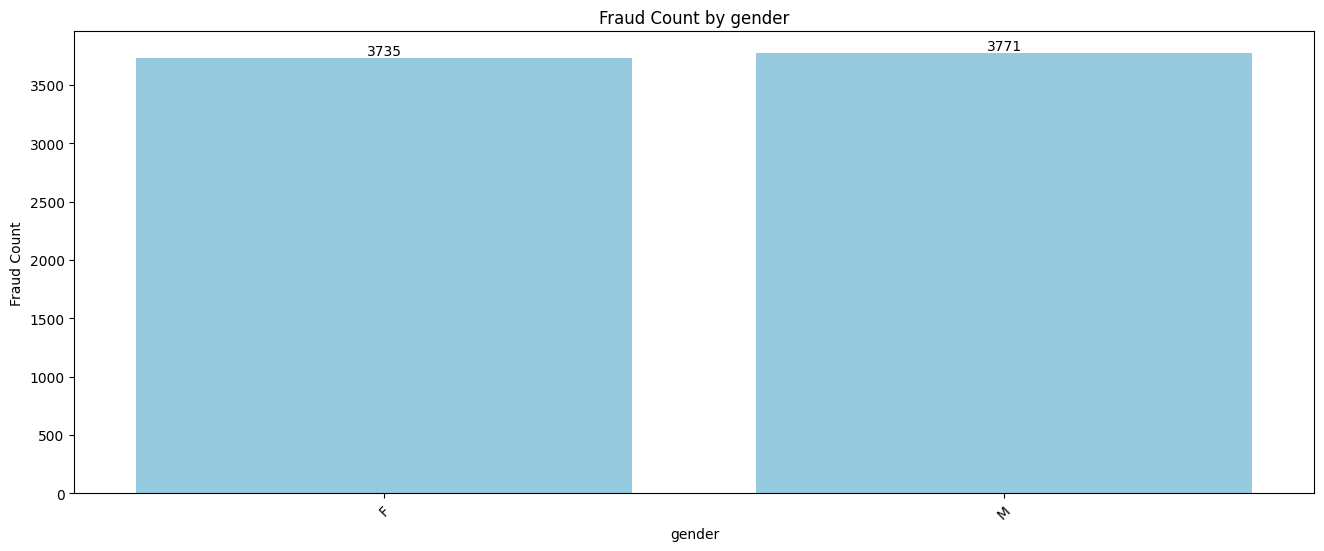

In [ ]:
def fraud_countplot(df, column):
    # Count how many frauds per unique value in column
    fraud_counts = df.groupby(column)["is_fraud"].sum().reset_index()

    plt.figure(figsize=(16,6))
    ax = sns.barplot(
        data=fraud_counts,
        x=column,
        y="is_fraud",
        color="skyblue"   # fraud counts in red
    )

    # Add count labels on top of bars
    for p in ax.patches:
        ax.annotate(
            f"{int(p.get_height())}",      # label = fraud count
            (p.get_x() + p.get_width()/2, p.get_height()),  # position at top
            ha="center", va="bottom",
            fontsize=10, color="black", rotation=0
        )

    plt.title(f"Fraud Count by {column}")
    plt.ylabel("Fraud Count")
    plt.xticks(rotation=45)
    plt.show()

fraud_countplot(df_viz, "gender")

In [ ]:
# from sklearn.preprocessing import LabelEncoder
# from scipy.stats import chi2_contingency

# def cramers_v(x, y):
#     confusion_matrix = pd.crosstab(x, y)
#     chi2 = chi2_contingency(confusion_matrix)[0]
#     n = confusion_matrix.sum().sum()
#     phi2 = chi2/n
#     r,k = confusion_matrix.shape
#     phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
#     rcorr = r - ((r-1)**2)/(n-1)
#     kcorr = k - ((k-1)**2)/(n-1)
#     return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# # Select categorical columns
# cat_cols = df.select_dtypes(include=["object"])

# # Encode to categorical (for correlation matrix loop)
# cat_encoded = cat_cols.apply(lambda col: LabelEncoder().fit_transform(col.astype(str)))

# # Compute Cramér’s V matrix
# corr_cat = pd.DataFrame(np.zeros((len(cat_cols.columns), len(cat_cols.columns))),
#                         index=cat_cols.columns, columns=cat_cols.columns)

# for c1 in cat_cols.columns:
#     for c2 in cat_cols.columns:
#         corr_cat.loc[c1, c2] = cramers_v(cat_encoded[c1], cat_encoded[c2])

# # Mask upper triangle
# mask = np.triu(np.ones_like(corr_cat, dtype=bool))

# plt.figure(figsize=(10,8))
# sns.heatmap(corr_cat, mask=mask, cmap="coolwarm", annot=True, fmt=".2f", cbar=True)
# plt.title("Categorical Features Correlation (Cramér’s V)")
# plt.show()

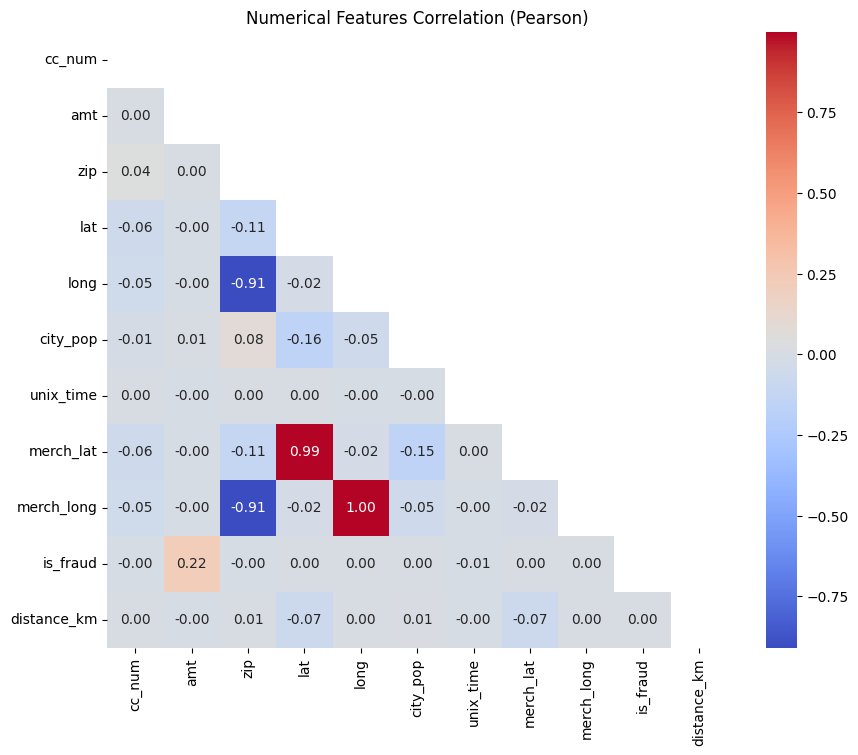

In [ ]:
num_cols = df_viz.select_dtypes(include=['int64', 'float64'])

# Pearson correlation
corr_num = num_cols.corr()

# Mask upper triangle
mask = np.triu(np.ones_like(corr_num, dtype=bool))

plt.figure(figsize=(10,8))
sns.heatmap(corr_num, mask=mask, cmap="coolwarm", annot=True, fmt=".2f", cbar=True)
plt.title("Numerical Features Correlation (Pearson)")
plt.show()